# Automatic peak finding and calibration tools in Becquerel

`Becquerel` contains tools for obtaining a rough first calibration for an uncalibrated `Spectrum`.

First, some imports:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import becquerel as bq
from becquerel.core.peakfinder import BoxcarPeakFilter, GaussianPeakFilter, PeakFinder
from becquerel.core.autocal import AutoCalibrator

Also some function definitions:

In [2]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, len(spectrum))
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()


def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for chan, erg in zip(cal.fit_channels, cal.fit_energies):
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([chan, chan], [1e-1, y], 'r-', alpha=0.5)
        plt.text(chan, y, '{:.1f} keV'.format(erg))

    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        chan = int(erg / cal.gain)
        y = cal.peakfinder.spectrum.counts_vals[chan-20:chan+20].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))

## `PeakFilter` classes

Instances of `PeakFilter` classes generate energy-dependent kernels that can be convolved with a spectrum to extract lines from the background continuum. To instantiate a kernel, the FWHM in channels at a specific channel is required, and the kernel scales the FWHM so that it is proportional to the square root of the channel (approximating the energy resolution of a detector).

Here is what a `BoxcarPeakFilter` and `GaussianDerivPeakFilter` look like:

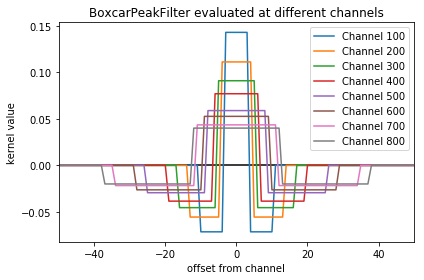

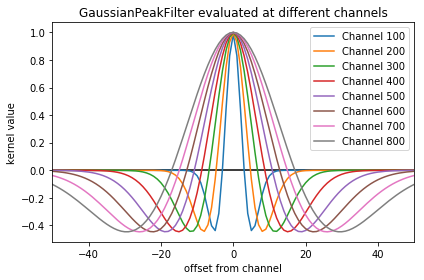

In [3]:
# demonstrate energy-dependent kernels
channels = np.arange(1000)
for kernel in [BoxcarPeakFilter(1000, 30, 5), GaussianPeakFilter(1000, 50, 5)]:
    plt.figure()
    plt.title('{} evaluated at different channels'.format(type(kernel).__name__))
    ind = np.arange(1000)

    plt.plot([-50, 50], [0, 0], 'k-')
    for chan in range(100, 900, 100):
        kern = kernel.kernel(chan, 1000)
        plt.plot(ind - chan, kern, '-', lw=1.5, label='Channel {}'.format(chan))
    plt.xlim(-50, 50)
    plt.xlabel('offset from channel')
    plt.ylabel('kernel value')
    plt.legend()
    plt.tight_layout()

We will use the `GaussiaPeakKernel` from now on.

A kernel can create a matrix that can be multiplied with a spectrum to perform the convolution. Here is what such a matrix could look like:

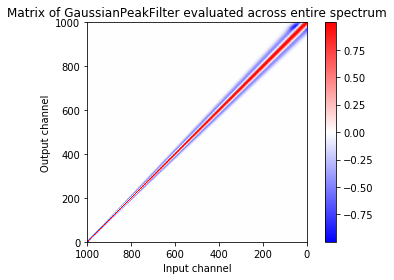

In [4]:
# display the kernel matrix
kernel = GaussianPeakFilter(1000, 50, 5)

plt.figure()
plt.title('Matrix of GaussianPeakFilter evaluated across entire spectrum')
kernel.plot_matrix(1000)
plt.tight_layout()

## `PeakFinder` and `AutoCalibrator` classes

The `PeakFinder` class allows one to automatically select peaks that a `PeakFilter` filters out of the spectrum.

The `AutoCalibrator` class takes the peaks found by a `PeakFinder` and finds the most likely energies associated with those peaks.

It is easiest to explain these classes using examples.

## Example 1: Calibrating a scintillator spectrum

First we read in a raw spectrum from file (this is a simulated background spectrum for a scintillator):

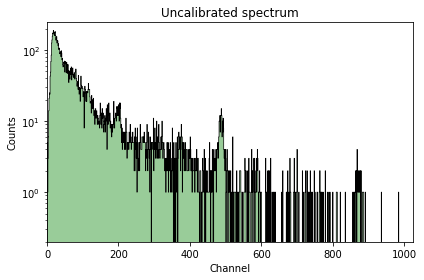

In [5]:
counts = []
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/sim_spec.csv')
with open(filename, 'r') as f:
    for line in f:
        tokens = line.strip().split(',')
        if len(tokens) == 2:
            counts.append(float(tokens[1]))
spec = bq.Spectrum(counts=counts)
plot_spec(spec)

To filter this spectrum we will use a kernel with a width of 50 channels at 500 channels, to match the strong line in the center (most likely the K-40 line at 1460 keV):

In [6]:
kernel = GaussianPeakFilter(500, 50, fwhm_at_0=10)

### 1.1 `PeakFinder` class

The `PeakFinder` class uses a `PeakFilter` to filter and calibrate the spectrum.

Under the hood, the kernel estimates the SNR of each peak by separating peaks from the background continuum. We can introspect this process using the `PeakFinder` instance:

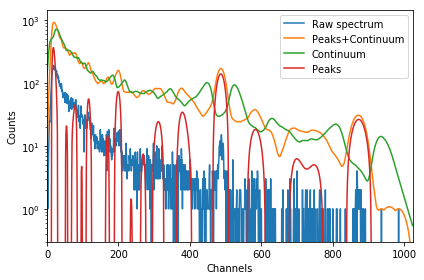

In [7]:
# show how the kernel estimates the peaks+background and the background
finder = PeakFinder(spec, kernel)

plt.figure()
plt.plot(spec.counts_vals.clip(1e-1), label='Raw spectrum')
plt.plot(finder._peak_plus_bkg.clip(1e-1), label='Peaks+Continuum')
plt.plot(finder._bkg.clip(1e-1), label='Continuum')
plt.plot(finder._signal.clip(1e-1), label='Peaks')
plt.yscale('log')
plt.xlim(0, len(spec))
plt.ylim(3e-1)
plt.xlabel('Channels')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()

The kernel applied directly to the spectral count data produces the estimated signal-to-noise (SNR) of each peak.

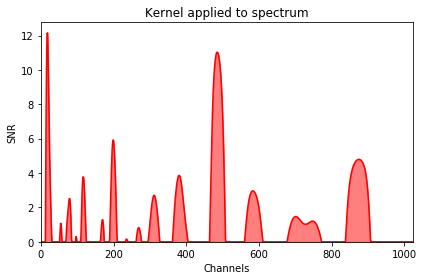

In [8]:
# plot signal to noise
plt.figure()
plt.title('Kernel applied to spectrum')
finder.plot()
plt.tight_layout()

### 1.2 Using `find_peak` to find a specific peak

Use the method `find_peak` to find a specific peak in the spectrum.

Let's try to locate the index of the tallest peak, right in the middle of the spectrum:

485


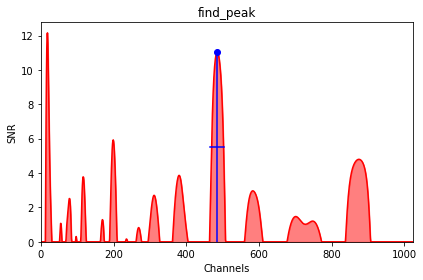

In [9]:
peak_chan = finder.find_peak(500, min_snr=3.)
print(peak_chan)

plt.figure()
plt.title('find_peak')
finder.plot()
plt.tight_layout()

Subsequent calls to `find_peak` will store the any new results:

875


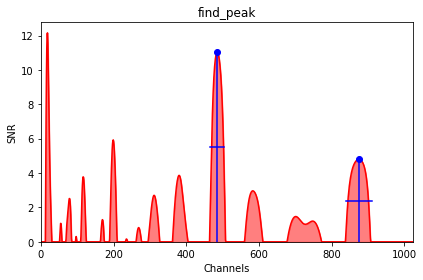

In [10]:
peak_chan = finder.find_peak(900, min_snr=3.)
print(peak_chan)

plt.figure()
plt.title('find_peak')
finder.plot()
plt.tight_layout()

#### 1.2 Use `reset` to remove all candidate peaks and calibration data

The list of candidate peaks will persist in the `PeakFinder` object, as will any calibration information (will be covered later).

Resetting the current object yields:

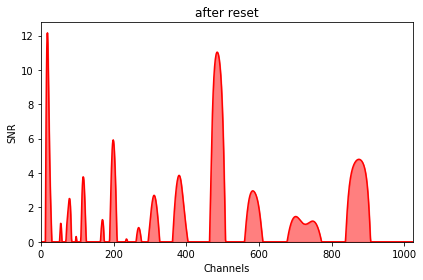

In [11]:
finder.reset()

plt.figure()
plt.title('after reset')
finder.plot()
plt.tight_layout()

### 1.2 Using `find_peaks` to find all peaks above an SNR threshold

Instead of repeatedly calling `find_peak`, one can build up a set of peak candidates using `find_peaks`. The following locates all peaks above channel 50 and an SNR of 2:

[78, 116, 198, 311, 380, 485, 583, 701, 747, 875]
[2.5168534119416344, 3.781928648553796, 5.887621421524213, 2.703591535322927, 3.866488183895824, 11.035623229046607, 2.965777846621912, 1.4712590957327307, 1.2046827609701043, 4.799899443854764]


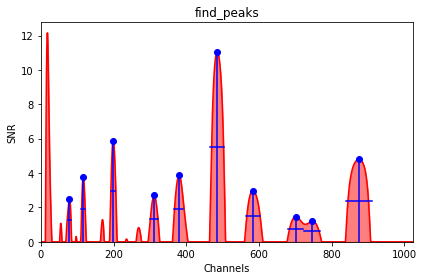

In [12]:
finder.find_peaks(min_snr=1, min_chan=50)
print(finder.channels)
print(finder.snrs)

plt.figure()
plt.title('find_peaks')
finder.plot()
plt.tight_layout()

### 1.4 The `AutoCalibrator.fit` method

The main machinery of auto-calibration is the `fit` method, which matches peak candidates (e.g., the outputs of `find_peaks`) with specific line energies and keeps the best match:

fit gain: 3.010224964347884 keV/channel
fit channels: [ 78 116 198 485 701 875]


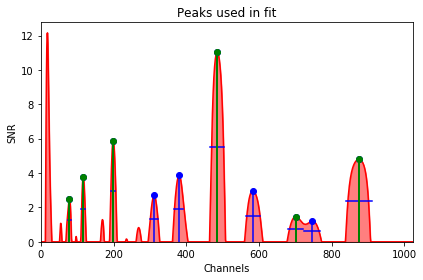

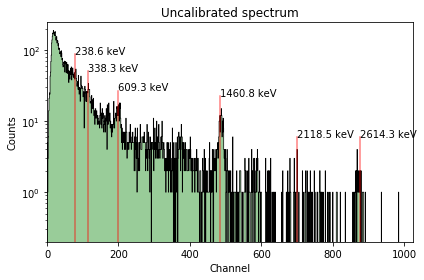

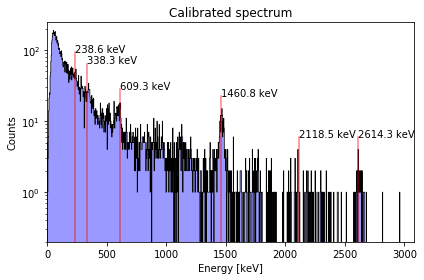

In [13]:
cal = AutoCalibrator(finder)
cal.fit(
    [609.32, 1460.82, 2614.3],
    optional=[238.63, 338.32, 351.93, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[2.5, 4.],
    de_max=20.,
)
plot_calibrator(cal)

### 1.5 `AutoCalibrator.fit` with only one peak

A special case of the calibrator is when only one peak has been found and only one energy is given. Use this with caution since there is none of the cross-validation that comes with multiple lines.

fit gain: 3.012 keV/channel
fit channels: [485]


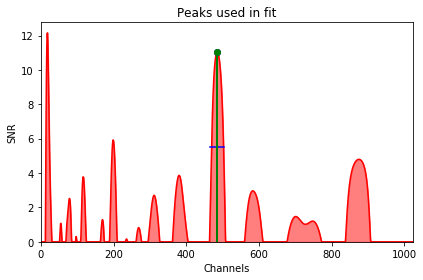

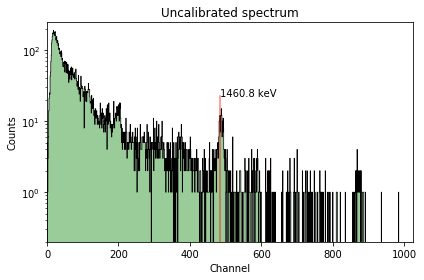

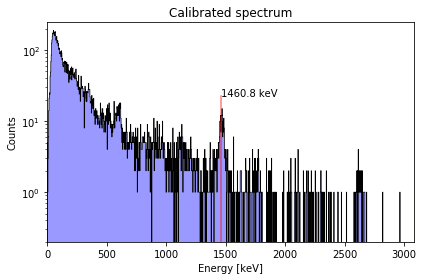

In [14]:
cal.peakfinder.reset()
cal.peakfinder.find_peak(500, min_snr=3.)
cal.fit([1460.82], gain_range=[2.5, 4.], de_max=20.)
plot_calibrator(cal)

## Example 2: Calibrating an HPGe spectrum

Let's perform the same calibration steps using an HPGe spectrum. This spectrum will have many more lines to fit.

SpeFile: Reading file /Users/msbandstra/Dropbox/Projects/Becquerel/becquerel-autocal/becquerel/../tests/samples/Mendocino_07-10-13_Acq-10-10-13.Spe
Line 8207 unknown:  $PRESETS:
Line 8208 unknown:  None
Line 8209 unknown:  0
Line 8210 unknown:  0


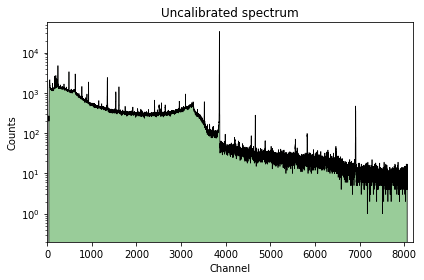

In [15]:
# read raw HPGe data
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/Mendocino_07-10-13_Acq-10-10-13.Spe')
spec = bq.Spectrum.from_file(filename)
plot_spec(spec)

We will again use a `GaussianDerivKernel`, but this one must be much narrower to match the resolution. Not surprisingly, the peaks in the spectrum have much higher SNR values:

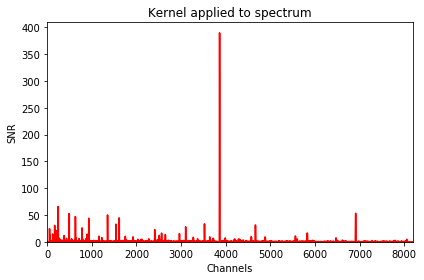

In [16]:
# apply the kernel to the data to get SNR
kernel = GaussianPeakFilter(3700, 10, 5)
finder = PeakFinder(spec, kernel)
cal = AutoCalibrator(finder)

plt.figure()
plt.title('Kernel applied to spectrum')
cal.peakfinder.plot()
plt.tight_layout()

[490, 630, 779, 929, 1350, 1540, 1610, 2407, 2560, 2960, 3100, 3520, 3860, 4662, 5824, 6908]
[49.59234105490095, 47.23852167731095, 21.36001665621997, 38.101594223047485, 50.11837754850629, 29.16370205165224, 44.68725649172067, 21.403883679982588, 15.850458814323755, 15.447958253311013, 28.026263217870387, 31.9806078886482, 389.59059882031465, 31.46935746860989, 16.538335872185474, 53.169992161426734]


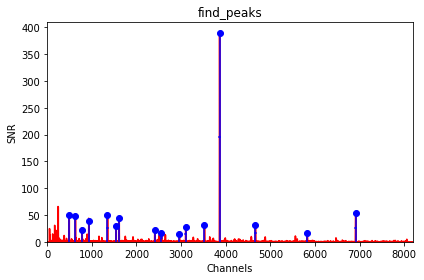

In [17]:
# find significant peaks
cal.peakfinder.find_peaks(min_snr=15, min_chan=400)
print(cal.peakfinder.channels)
print(cal.peakfinder.snrs)

plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

fit gain: 0.37845268891430145 keV/channel
fit channels: [ 630  929 1610 2407 2960 3860 4662 6908]


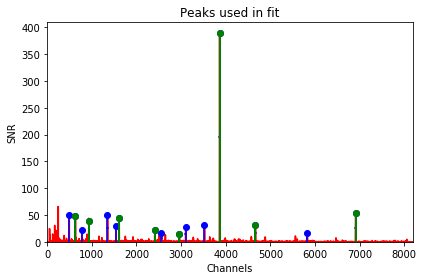

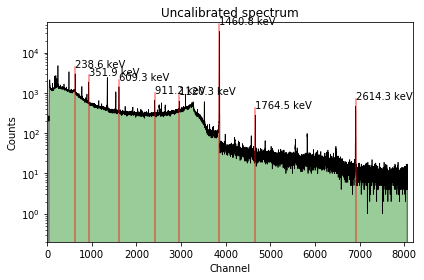

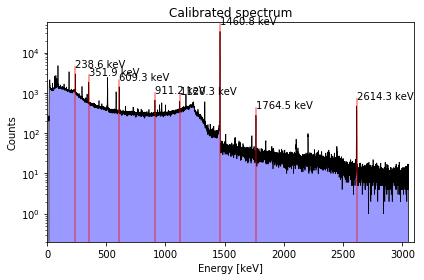

In [18]:
# perform calibration
cal.fit(
    [238.63, 351.93, 609.32, 1460.82, 2614.3],
    optional=[338.32, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 0.4],
    de_max=5.,
)
plot_calibrator(cal)

## Example 3: An unusual NaI spectrum

This example shows a real spectrum from a NaI detector with very poor energy resolution and where the dynamic range has cut off the higher energies. Can we still calibrate it?

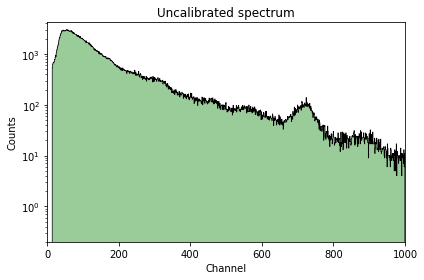

In [19]:
counts = []
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/nai_detector.csv')
with open(filename, 'r') as f:
    for line in f:
        tokens = line.strip().split(',')
        if len(tokens) == 2:
            counts.append(float(tokens[1]))
spec = bq.Spectrum(counts=counts)
plot_spec(spec)

[118, 176, 322, 462, 561, 721, 879]
[3.125036717887065, 4.351059385201733, 5.1956306416680205, 5.3847239014866775, 4.5994095502989145, 26.641363684972838, 4.174476906815713]


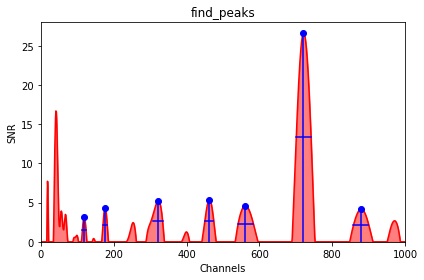

In [20]:
kernel = GaussianPeakFilter(700, 50, 10)
finder = PeakFinder(spec, kernel)
cal = AutoCalibrator(finder)

# find significant peaks
cal.peakfinder.find_peaks(min_snr=3, min_chan=100)
print(cal.peakfinder.channels)
print(cal.peakfinder.snrs)

plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

fit gain: 3.2217239895170997 keV/channel
fit channels: [176 462]


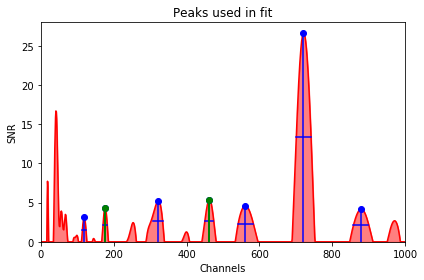

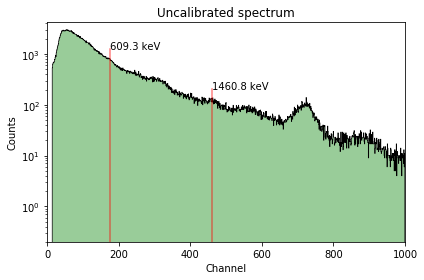

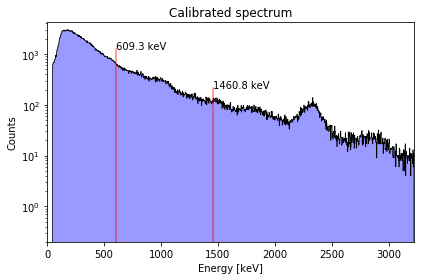

In [21]:
# perform calibration
cal.fit(
    [609.32, 1460.82],
    optional=[],
    gain_range=[0.1, 5.],
    de_max=50.,
)
plot_calibrator(cal)

That did not work right, the calibrator matched with the wrong lines. To fix this, we could either increase `min_chan` to exclude the lower energy lines, increase `min_snr` to exclude the lower significance lines, or add optional energies. Let's try the same fit but with a longer list of prominent background lines:

fit gain: 2.0214886961901826 keV/channel
fit channels: [118 176 322 462 561 721 879]


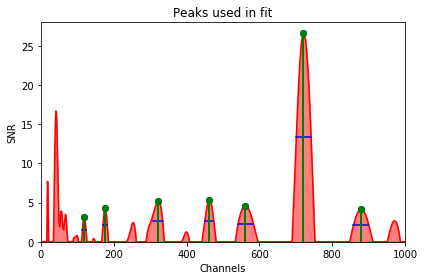

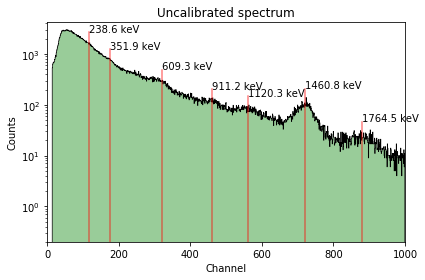

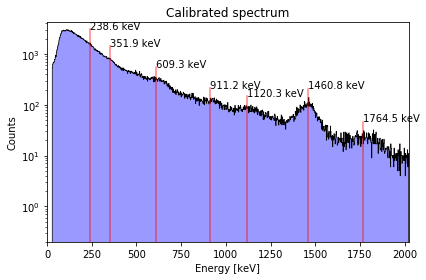

In [22]:
# perform calibration again, but with more optional energies
cal.fit(
    [609.32, 1460.82],
    optional=[238.63, 338.32, 351.93, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.1, 5.],
    de_max=50.,
)
plot_calibrator(cal)

Success! The cross-validation used in `AutoCalibrator.fit` was able to find a better match.

## Example 4: CsI detector with Ba-133 and Cs-137 sources

This data is from a small detector with Ba-133 and Cs-137 sources near it. We want to use those sources' lines and any strong backgroud lines to calibrate it.

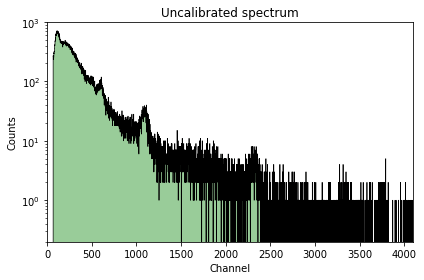

In [23]:
counts = []
filename = os.path.join(os.path.dirname(bq.__file__), '../tests/samples/SGM102432.csv')
with open(filename, 'r') as f:
    for line in f:
        tokens = line.strip().split(',')
        if len(tokens) == 2:
            counts.append(float(tokens[1]))
spec = bq.Spectrum(counts=counts)
plot_spec(spec)

[108, 509, 601, 1093, 2314, 3328, 3747]
[27.115616800824714, 4.552748757416729, 12.375421824417282, 14.072910929273128, 9.616744311580481, 3.300815263459304, 5.079052610540933]


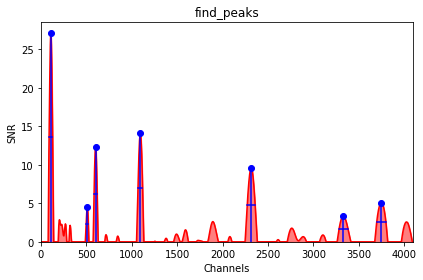

In [24]:
kernel = GaussianPeakFilter(2400, 120, 30)
finder = PeakFinder(spec, kernel)
cal = AutoCalibrator(finder)

# find significant peaks
cal.peakfinder.find_peaks(min_snr=3, min_chan=100)
print(cal.peakfinder.channels)
print(cal.peakfinder.snrs)

plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()

fit gain: 0.6136934152580631 keV/channel
fit channels: [ 601 1093 2314]


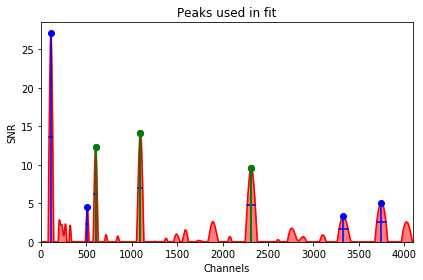

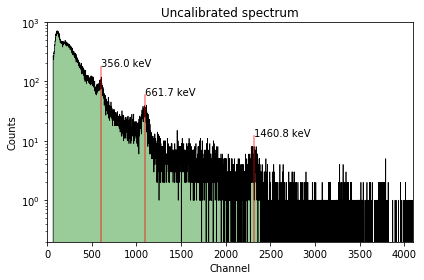

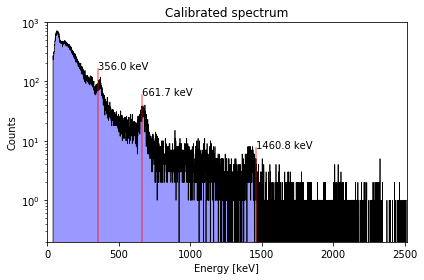

In [25]:
cal.fit(
    [356.0129, 661.657, 1460.82],
    optional=[911.20, 1120.294, 1620.50, 1764.49, 2118.514, 2614.3, 2118.514],
    gain_range=[0.3, 0.7],
    de_max=50.,
)
plot_calibrator(cal)

This last plot reveals that the 1460 keV peak does not quite line up with the calibration, so this detector probably exhibits a significant nonlinearity and would have to be calibrated with a more sophisticated method.